Задача 1. Выбор кредита от Tinkoff.ru
В credit_train.csv содержится 170746 строк с данными о клиентах сети магазинов электроники, в этих магазинах они подали заявки на кредит. Колонка open_account_flg содержит 1 если клиент выбрал Тинькофф и 0 в противном случае. В credit_test.csv содержится 91940 строк с данными, для каждой строки следует предсказать возьмет ли соответствующий ей человек кредит в Тинькофф.
Метрикой качества в задаче является AUC 

education - образование:

    SCH - начальное, среднее
    PGR -  второе высшее
    GRD - высшее
    UGR - неполное высшее
    ACD - ученая степень
    
    
job_position - работа

    SPC - неруководящий сотрудник, специалист
    DIR - руководитель организации
    HSK - домохозяйка
    INV - не работает, инвалидность
    WOI - работает на ИП
    WRK - неруководящий сотрудник, рабочий
    UMN -  руководитель подразделения
    NOR - не работает
    PNS - пенсионер
    BIS - собственный бизнес 
    INP - ИП
   
marital_status - семейное положение

    UNM - холост/не замужем
    DIV - разведен(а)
    MAR - женат/замужем
    WID - вдовец/вдова
    CIV - гражданский брак
    
gender - пол 

age - возраст

credit_sum - сумма кредита

credit_month - срок кредитования

tariff_id - номер предлагаемого тарифа

living_region - регион проживания

montly_income - заработная плата в месяц

credit_count - количество кредитов у клиента

overdue_credit_count - количество просроченных кредитов

score_shk - неизвестный индекс кредитоспособности
    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation

/Users/Roman/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
train = pd.read_csv("../credit_train.csv", sep = ";", encoding='cp1251')
test = pd.read_csv("../credit_test.csv", sep = ";", encoding='cp1251')

In [5]:
train.head(2)

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,"59998,00",10,1.6,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,"10889,00",6,1.1,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0


In [6]:
y = train['open_account_flg']

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
client_id               170746 non-null int64
gender                  170746 non-null object
age                     170746 non-null int64
marital_status          170746 non-null object
job_position            170746 non-null object
credit_sum              170746 non-null object
credit_month            170746 non-null int64
tariff_id               170746 non-null float64
score_shk               170746 non-null object
education               170746 non-null object
living_region           170554 non-null object
monthly_income          170745 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(4), int64(4), object(7)
memory usage: 19.5+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91940 entries, 0 to 91939
Data columns (total 14 columns):
client_id               91940 non-null int64
gender                  91940 non-null object
age                     91940 non-null int64
marital_status          91940 non-null object
job_position            91940 non-null object
credit_sum              91940 non-null object
credit_month            91940 non-null int64
tariff_id               91940 non-null float64
score_shk               91940 non-null object
education               91940 non-null object
living_region           91824 non-null object
monthly_income          91940 non-null int64
credit_count            87237 non-null float64
overdue_credit_count    87237 non-null float64
dtypes: float64(3), int64(4), object(7)
memory usage: 9.8+ MB


I работа с пропусками в данных

In [10]:
train[train.monthly_income.isnull() == True]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
19639,19640,F,33,MAR,BIS,"13009,00",10,1.6,"0,535834",SCH,ПРИМОРСКИЙ КРАЙ,NaN,2.0,0.0,0


In [11]:
train.monthly_income.fillna(train.monthly_income.mean(), inplace=True)

In [12]:
train.living_region.fillna(value="Unknown", inplace=True)
test.living_region.fillna(value="Unknown", inplace=True)

In [14]:
train.credit_count.fillna(value = train.credit_count.mean(), inplace=True)
train.overdue_credit_count.fillna(value = train.overdue_credit_count.mean(), inplace=True)

In [13]:
test.credit_count.fillna(value = train.credit_count.mean(), inplace=True)
test.overdue_credit_count.fillna(value = train.overdue_credit_count.mean(), inplace=True)

In [17]:
train.job_position.unique()

array(['UMN', 'SPC', 'INP', 'DIR', 'ATP', 'PNA', 'BIS', 'WOI', 'NOR',
       'WRK', 'WRP', 'PNV', 'BIU', 'PNI', 'HSK', 'PNS', 'INV', 'ONB'], dtype=object)

In [24]:
train.marital_status.unique()

array(['MAR', 'DIV', 'UNM', 'WID', 'CIV'], dtype=object)

In [35]:
train.groupby("job_position").target.mean()

job_position
ATP    0.289144
BIS    0.158290
BIU    0.365079
DIR    0.148000
HSK    0.250000
INP    0.278008
INV    0.800000
NOR    0.361266
ONB    1.000000
PNA    0.362552
PNI    0.307692
PNS    0.500000
PNV    0.225000
SPC    0.166342
UMN    0.188978
WOI    0.238636
WRK    0.184451
WRP    0.209091
Name: target, dtype: float64

In [36]:
train.groupby("education").target.mean()

education
ACD    0.233645
GRD    0.139543
PGR    0.191150
SCH    0.205120
UGR    0.184790
Name: target, dtype: float64

In [37]:
train.groupby("marital_status").target.mean()

marital_status
CIV    0.201621
DIV    0.182086
MAR    0.152923
UNM    0.211241
WID    0.211799
Name: target, dtype: float64

In [58]:
train.groupby("tariff_id").target.mean()

tariff_id
1.00    0.070824
1.10    0.190181
1.16    0.107983
1.17    0.171548
1.18    0.916667
1.19    0.111798
1.20    0.097243
1.21    0.029361
1.22    0.037234
1.23    0.040541
1.24    0.155116
1.25    0.232143
1.26    0.090909
1.27    0.000000
1.28    0.000000
1.29    1.000000
1.30    0.297095
1.32    0.377550
1.40    0.114221
1.41    0.196970
1.43    0.120611
1.44    0.127917
1.48    0.000000
1.50    0.096839
1.52    0.000000
1.56    0.000000
1.60    0.140987
1.70    0.101291
1.90    0.066631
1.91    0.246057
1.94    0.111111
1.96    0.000000
Name: target, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bf99400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1251692b0>]], dtype=object)

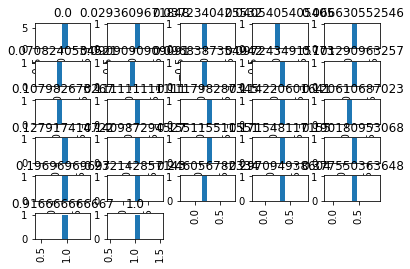

In [81]:
tmp = pd.DataFrame(train.groupby("tariff_id").target.mean())
tmp.
tmp.hist(by="target")

In [79]:
tmp.head()

,target
tariff_id,
1.00,0.070824
1.10,0.190181
1.16,0.107983
1.17,0.171548
1.18,0.916667


In [40]:
test[test.job_position == "INV"]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
8203,178950,1,26,UNM,INV,"14598,00",10,1.6,"0,578977",SCH,РЕСПУБЛИКА ТАТАРСТАН,11000,0.0,0.0
63304,234051,0,67,UNM,INV,"13809,00",10,1.6,"0,619240",SCH,ПРИМОРСКИЙ КРАЙ,9400,3.0,1.0


In [26]:
train.gender = train.gender.map({"M":1, "F":0})
test.gender = test.gender.map({"M":1, "F":0})

In [27]:
train.rename(columns={"open_account_flg":"target"}, inplace=True)

II сделать сбалансированные классы

In [13]:
count_to_add = abs (np.sum(train.target == 1) - np.sum(train.target == 0))
indices_to_add = np.random.randint(np.sum(train.target == 1), size = count_to_add)
train_to_add = pd.DataFrame(data = train.values[train.target.as_matrix() == 1][indices_to_add,:], columns=train.columns)

In [14]:
train = pd.concat([train, train_to_add], axis=0)

In [15]:
y = train.target

II выделим группы людей по наличию высшего образования, работе и пенсии 

In [16]:
### по образованию
train["high_edu"] = ((train["education"] != "SCH") & (train["education"] != "UGR"))

### по работе
# 1. не работающие граждание
train["not_work"] = ((train.job_position == "HSK") | (train.job_position == "INV") 
                     | (train.job_position == "NOR") | (train.job_position == "PNS"))

# 2. обычные работники
train["usual_workers"] = ((train.job_position == "SPC") | (train.job_position == "WOI") 
                     | (train.job_position == "WRK") | (train.job_position == "ATP") 
                     | (train.job_position == "WRP"))

# 3. начальники
train["head_workers"] = ((train.job_position == "DIR") | (train.job_position == "UMN")
                         | (train.job_position == "BIS") | (train.job_position == "INP"))

# 4. имеют собственный бизнес
train["have_business"] = ((train.job_position == "BIS") | (train.job_position == "INP"))

### по браку
train["single"] = ((train.marital_status == "UNM") | (train.marital_status == "DIV")
                   | (train.marital_status == "WID"))

In [17]:
### по образованию
test["high_edu"] = ((test["education"] != "SCH") & (test["education"] != "UGR"))

### по работе
# 1. не работающие граждание
test["not_work"] = ((test.job_position == "HSK") | (test.job_position == "INV") 
                     | (test.job_position == "NOR") | (test.job_position == "PNS"))

# 2. обычные работники
test["usual_workers"] = ((test.job_position == "SPC") | (test.job_position == "WOI") 
                     | (test.job_position == "WRK") | (test.job_position == "ATP") 
                     | (test.job_position == "WRP"))

# 3. начальники
test["head_workers"] = ((test.job_position == "DIR") | (test.job_position == "UMN")
                         | (test.job_position == "BIS") | (test.job_position == "INP"))

# 4. имеют собственный бизнес
test["have_business"] = ((test.job_position == "BIS") | (test.job_position == "INP"))

### по браку
test["single"] = ((test.marital_status == "UNM") | (test.marital_status == "DIV")
                   | (test.marital_status == "WID"))

III кодировка категориальных признаков, кроме living region

In [18]:
train_col = train.columns.drop("target")

In [19]:
dummy_df = pd.concat([train[train_col], test], axis=0)

In [20]:
dummy_df = pd.get_dummies(dummy_df, columns=["education","job_position", "marital_status"], drop_first=True)

In [21]:
train = dummy_df[:train.shape[0]]
test = dummy_df[train.shape[0]:]

In [22]:
train.columns

Index(['client_id', 'gender', 'age', 'credit_sum', 'credit_month', 'tariff_id',
       'score_shk', 'living_region', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'high_edu', 'not_work', 'usual_workers',
       'head_workers', 'have_business', 'single', 'education_GRD',
       'education_PGR', 'education_SCH', 'education_UGR', 'job_position_BIS',
       'job_position_BIU', 'job_position_DIR', 'job_position_HSK',
       'job_position_INP', 'job_position_INV', 'job_position_NOR',
       'job_position_ONB', 'job_position_PNA', 'job_position_PNI',
       'job_position_PNS', 'job_position_PNV', 'job_position_SPC',
       'job_position_UMN', 'job_position_WOI', 'job_position_WRK',
       'job_position_WRP', 'marital_status_DIV', 'marital_status_MAR',
       'marital_status_UNM', 'marital_status_WID'],
      dtype='object')

IV кодировка региона через среднюю зарплату

In [23]:
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

In [24]:
train['monthly_income'] = train['monthly_income'].astype(float)
test['monthly_income'] = test['monthly_income'].astype(float)

train["city_mean_income"] = code_mean(train, 'living_region', 'monthly_income')
train.city_mean_income.fillna(value=train.city_mean_income.mean(), inplace=True)
train.drop("living_region", axis=1, inplace=True)

test["city_mean_income"] = code_mean(test, 'living_region', 'monthly_income')
test.city_mean_income.fillna(value=train.city_mean_income.mean(), inplace=True)
test.drop("living_region", axis=1, inplace=True)

/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

V Генерация данных о зарплате и выплатам по кредиту

In [25]:
train['credit_sum'] = train['credit_sum'].apply(lambda x: x.replace(",","."))
test['credit_sum'] = test['credit_sum'].apply(lambda x: x.replace(",","."))

train['credit_sum'] = train['credit_sum'].astype(float)
test['credit_sum'] = test['credit_sum'].astype(float)

/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

credit_pay - ежемесячный расход на кредит

money_for_life - разность между зп и платой по кредиту

dif_city - разница между зп и средней зп по региону

In [26]:
train["credit_pay"] = train["credit_sum"] / train["credit_month"]
train["money_for_life"] = train["monthly_income"] - train["credit_pay"]
train["dif_city"] = train["monthly_income"] - train["city_mean_income"]

test["credit_pay"] = test["credit_sum"] / test["credit_month"]
test["money_for_life"] = test["monthly_income"] - test["credit_pay"]
test["dif_city"] = test["monthly_income"] - test["city_mean_income"]

/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

VI анализ score_shk

In [27]:
train['score_shk'] = train['score_shk'].apply(lambda x: x.replace(",","."))
test['score_shk'] = test['score_shk'].apply(lambda x: x.replace(",","."))

train['score_shk'] = train['score_shk'].astype(float)
test['score_shk'] = test['score_shk'].astype(float)

/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [28]:
train['target'] = y

/Users/Roman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281380 entries, 0 to 110633
Data columns (total 46 columns):
client_id               281380 non-null object
gender                  281380 non-null object
age                     281380 non-null object
credit_sum              281380 non-null float64
credit_month            281380 non-null object
tariff_id               281380 non-null object
score_shk               281380 non-null float64
monthly_income          281380 non-null float64
credit_count            281380 non-null object
overdue_credit_count    281380 non-null object
high_edu                281380 non-null bool
not_work                281380 non-null bool
usual_workers           281380 non-null bool
head_workers            281380 non-null bool
have_business           281380 non-null bool
single                  281380 non-null bool
education_GRD           281380 non-null uint8
education_PGR           281380 non-null uint8
education_SCH           281380 non-null uint8
educatio

In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91940 entries, 0 to 91939
Data columns (total 45 columns):
client_id               91940 non-null object
gender                  91940 non-null object
age                     91940 non-null object
credit_sum              91940 non-null float64
credit_month            91940 non-null object
tariff_id               91940 non-null object
score_shk               91940 non-null float64
monthly_income          91940 non-null float64
credit_count            91940 non-null object
overdue_credit_count    91940 non-null object
high_edu                91940 non-null bool
not_work                91940 non-null bool
usual_workers           91940 non-null bool
head_workers            91940 non-null bool
have_business           91940 non-null bool
single                  91940 non-null bool
education_GRD           91940 non-null uint8
education_PGR           91940 non-null uint8
education_SCH           91940 non-null uint8
education_UGR           91940

In [31]:
train.to_csv("train_random_oversampling.csv", columns=train.columns, index=False)
test.to_csv("test.csv", columns=test.columns, index=False)